In [1]:
import warnings
warnings.filterwarnings("ignore")
import modulesForCalibration as mfc
import matplotlib.pyplot as plt

#import readPlotOptionSurface_granular_k2_5 as marketSurface
import readPlotPutSurfaceedited as marketSurface
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import cmath
import math
from scipy.optimize import fmin


import plotly.plotly as py
import plotly.graph_objs as go

<Figure size 800x600 with 1 Axes>

# This report reflects the work of Lisa He, Alban Zapke, and Naijia Yao, for the project of volatility surface in Computational Methods in Finance with Prof. Hirsa.

## APPL

###  We set up Grid for Model Prices as provided in readPlotOptionSurface.py provided by Prof. Hirsa

### deltaK = 5 & deltaTau = 1/52

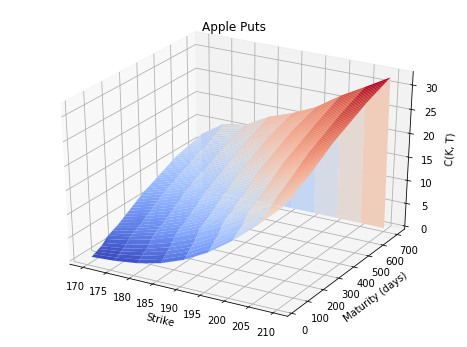

In [2]:
maturities, strikes, marketPrices = marketSurface.readNPlot()

In [3]:
maturities_years = maturities/365

# I. Model Prices

### Global Parameters

In [4]:
# Contract Parameters
S0 = 190
K = 190
k = np.log(K)
# risk free rate
r = 0.0245
# dividend rate
q = 0.005

# Parameters
alpha = -1.5                      # alpha is negative for puts
eta = 0.2

n = 12
N = 2**n

# step-size in log strike space  --> FFT constraint
#lda = (2*np.pi/N)/eta

# Choice of beta
#beta = np.log(S0)-N*lda/2
# beta = np.log(K)

* Grid for Model Prices was set up in readPlotOptionSurface

## 1. Finding a starting point; code provided as in exampleCalibration_FindingStartingPoint.py by Prof. Hirsa

In [5]:
iArray = []                             # The alphas (0,1) which are plotted agains RMSE -> calling it i instead here
rmseArray = []
rmseMin = 1e10                          # Random; in order to have an error to start with

### Model specific parameters:

#### Heston 

In [6]:
model = 'Heston'

#set 1: promising starting point
params1 = (1.0, 0.02, 0.05, -0.4, 0.08)
params2 = (3.0, 0.06, 0.10, -0.6, 0.04)

In [7]:
lenT = len(maturities_years)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

In [8]:
modelPrices.shape == marketPrices.shape

True

In [9]:
marketPrices.shape


(98, 9)

In [10]:
iArray = []
rmseArray=[]
for i in mfc.myRange(0.0, 1.0, 0.05):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

In [11]:
len(rmseArray) == len(iArray)
print(len(rmseArray))
print(len(iArray))
#print(rmseArray)
#print(iArray)

20
20


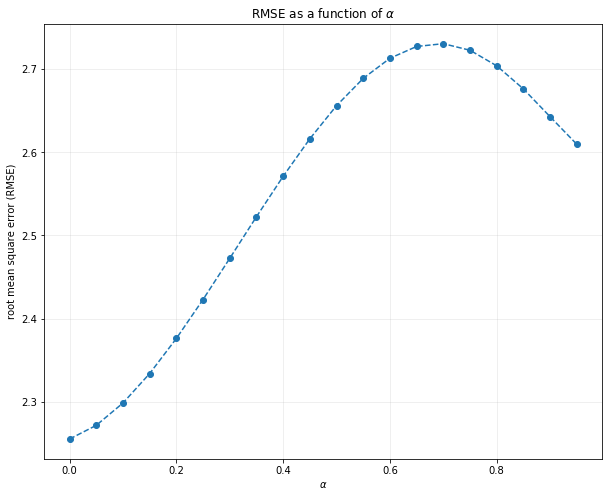

2.2551146094067405
[ 3.    0.06  0.1  -0.6   0.04]


In [12]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
plt.savefig('startingPoint4.png')
plt.show()

print(rmseMin)
print(optimParams)

In [13]:
# Starting point Parameters 
kappa = 3.
theta = 0.06
sig = 0.1
rho = -0.6
v0 = 0.04

## 2. Optimization of Parameter Set

#### - Objective Function -

In [14]:
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

In [15]:
lenT = len(maturities)
lenK = len(strikes)

#### A) Brute Force Algorithm 

In [16]:
# maturities, strikes, marketPrices = marketSurface.readNPlot()

#==========================================
# Grid Search around the starting point
#------------------------------------------
# [ 3.    0.06  0.1  -0.6   0.04]
ind_iter = 1
rmseMin = 1.0e6

for kappa in mfc.myRange(2.5,3.5,0.5):
    for theta in mfc.myRange(0.05,0.07,0.01):
        for sig in mfc.myRange(0.09,0.11,0.01):
            for rho in mfc.myRange(-0.7,-0.5,0.1):
                for v0 in mfc.myRange(0.03,0.05,0.01):
                    params = []
                    params.append(kappa)
                    params.append(theta)
                    params.append(sig)
                    params.append(rho)
                    params.append(v0)
                    
                    print('i = ' + str(ind_iter))
                    ind_iter += 1
                    print(params)
                    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
                    
                    if (rmse < rmseMin):
                        rmseMin = rmse
                        params2 = params
                        print('\nnew min found')
                        print(rmseMin)
                        print(params2)
                        print('')

print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))

i = 1
[2.5, 0.05, 0.09, -0.7, 0.03]

new min found
2.9370719539119503
[2.5, 0.05, 0.09, -0.7, 0.03]

i = 2
[2.5, 0.05, 0.09, -0.7, 0.04]

new min found
2.6289402217058453
[2.5, 0.05, 0.09, -0.7, 0.04]

i = 3
[2.5, 0.05, 0.09, -0.7, 0.05]

new min found
2.4239900324326014
[2.5, 0.05, 0.09, -0.7, 0.05]

i = 4
[2.5, 0.05, 0.09, -0.6, 0.03]
i = 5
[2.5, 0.05, 0.09, -0.6, 0.04]
i = 6
[2.5, 0.05, 0.09, -0.6, 0.05]

new min found
2.4234636944598416
[2.5, 0.05, 0.09, -0.6, 0.05]

i = 7
[2.5, 0.05, 0.09, -0.5, 0.03]
i = 8
[2.5, 0.05, 0.09, -0.5, 0.04]
i = 9
[2.5, 0.05, 0.09, -0.5, 0.05]

new min found
2.423227371621079
[2.5, 0.05, 0.09, -0.5, 0.05]

i = 10
[2.5, 0.05, 0.09999999999999999, -0.7, 0.03]
i = 11
[2.5, 0.05, 0.09999999999999999, -0.7, 0.04]
i = 12
[2.5, 0.05, 0.09999999999999999, -0.7, 0.05]
i = 13
[2.5, 0.05, 0.09999999999999999, -0.6, 0.03]
i = 14
[2.5, 0.05, 0.09999999999999999, -0.6, 0.04]
i = 15
[2.5, 0.05, 0.09999999999999999, -0.6, 0.05]
i = 16
[2.5, 0.05, 0.09999999999999999, 

i = 137
[3.0, 0.07, 0.09, -0.7, 0.04]
i = 138
[3.0, 0.07, 0.09, -0.7, 0.05]
i = 139
[3.0, 0.07, 0.09, -0.6, 0.03]
i = 140
[3.0, 0.07, 0.09, -0.6, 0.04]
i = 141
[3.0, 0.07, 0.09, -0.6, 0.05]
i = 142
[3.0, 0.07, 0.09, -0.5, 0.03]
i = 143
[3.0, 0.07, 0.09, -0.5, 0.04]
i = 144
[3.0, 0.07, 0.09, -0.5, 0.05]
i = 145
[3.0, 0.07, 0.09999999999999999, -0.7, 0.03]
i = 146
[3.0, 0.07, 0.09999999999999999, -0.7, 0.04]
i = 147
[3.0, 0.07, 0.09999999999999999, -0.7, 0.05]
i = 148
[3.0, 0.07, 0.09999999999999999, -0.6, 0.03]
i = 149
[3.0, 0.07, 0.09999999999999999, -0.6, 0.04]
i = 150
[3.0, 0.07, 0.09999999999999999, -0.6, 0.05]
i = 151
[3.0, 0.07, 0.09999999999999999, -0.5, 0.03]
i = 152
[3.0, 0.07, 0.09999999999999999, -0.5, 0.04]
i = 153
[3.0, 0.07, 0.09999999999999999, -0.5, 0.05]
i = 154
[3.0, 0.07, 0.10999999999999999, -0.7, 0.03]
i = 155
[3.0, 0.07, 0.10999999999999999, -0.7, 0.04]
i = 156
[3.0, 0.07, 0.10999999999999999, -0.7, 0.05]
i = 157
[3.0, 0.07, 0.10999999999999999, -0.6, 0.03]
i = 158

In [ ]:
# Solution of grid search:
# [3.5, 0.060000000000000005, 0.10999999999999999, -0.7, 0.04]
# Optimal rmse = 2.2481652284865006

#### - Market vs. Model Surface -

In [17]:
params2

[3.5, 0.060000000000000005, 0.10999999999999999, -0.7, 0.04]

In [18]:
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params2, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]

In [19]:
modelPrices.shape == marketPrices.shape

True

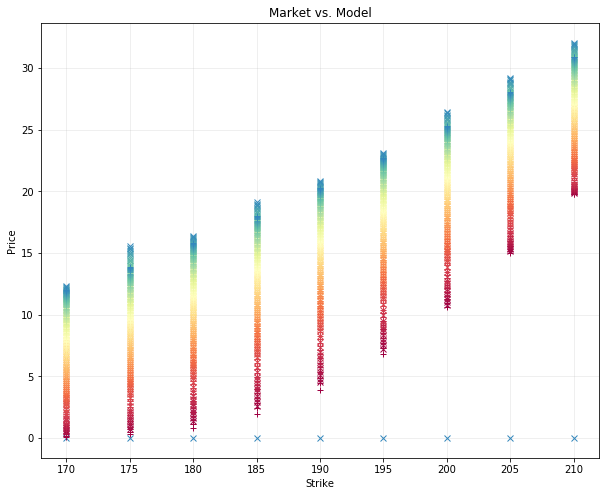

In [20]:
# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
    
#plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model')
plt.savefig('MarketvsModel_GridSearch.png')
plt.show() 

#### B) Nelder Mead Algorithm  (Gradient-free) from exampleCalibration_NelderMead.py

In [21]:
#==========================================
# Nelder-Mead Simplex Algorithm -- fmin
#==========================================
# [ 3.    0.06  0.1  -0.6   0.04]

params = [ 3.  ,  0.06,  0.1 , -0.6 ,  0.04]

def callbackF(xi):
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        mfc.eValue, 
        params, 
        args=arg, 
        xtol=1e-4,
        ftol=1e-4,
        maxiter=200,
        maxfun=400,
        callback=callbackF,
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

i = 1
x_i = [ 3.015   0.0615  0.1005 -0.603   0.0402]
f_i = 2.2495918894288636
i = 2
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 3
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 4
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 5
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 6
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 7
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 8
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 9
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 10
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 11
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 12
x_i = [ 3.099    0.0609   0.1033  -0.6198   0.04132]
f_i = 2.24880234036996
i = 13
x_i = [ 3

f_i = 2.2439431157849037
i = 86
x_i = [ 4.94652562  0.05988335  0.16340264 -1.06622993  0.0368811 ]
f_i = 2.2439431157849037
i = 87
x_i = [ 5.05192154  0.06002157  0.1728496  -1.10037206  0.03613787]
f_i = 2.243916292745714
i = 88
x_i = [ 5.05192154  0.06002157  0.1728496  -1.10037206  0.03613787]
f_i = 2.243916292745714
i = 89
x_i = [ 4.97765788  0.05987637  0.17188447 -1.08354874  0.03678737]
f_i = 2.243910773844858
i = 90
x_i = [ 5.22257697  0.05975415  0.18232899 -1.14389401  0.03628457]
f_i = 2.2438875892521986
i = 91
x_i = [ 5.20447374  0.05984391  0.18107776 -1.13459873  0.03627841]
f_i = 2.243883580925211
i = 92
x_i = [ 5.34830058  0.05990213  0.20230758 -1.19398062  0.03571727]
f_i = 2.2438320288259033
i = 93
x_i = [ 5.34830058  0.05990213  0.20230758 -1.19398062  0.03571727]
f_i = 2.2438320288259033
i = 94
x_i = [ 5.34830058  0.05990213  0.20230758 -1.19398062  0.03571727]
f_i = 2.2438320288259033
i = 95
x_i = [ 5.34830058  0.05990213  0.20230758 -1.19398062  0.03571727]
f_i 

f_i = 2.243726810534383
i = 168
x_i = [ 5.89405897  0.05996339  0.37865647 -1.52560925  0.03540377]
f_i = 2.243726810534383
i = 169
x_i = [ 5.92542659  0.06000175  0.38873387 -1.53804465  0.03524977]
f_i = 2.2437262224116434
i = 170
x_i = [ 5.97533034  0.060017    0.40563033 -1.55343449  0.03532998]
f_i = 2.243719259539534
i = 171
x_i = [ 5.97533034  0.060017    0.40563033 -1.55343449  0.03532998]
f_i = 2.243719259539534
i = 172
x_i = [ 5.97533034  0.060017    0.40563033 -1.55343449  0.03532998]
f_i = 2.243719259539534
i = 173
x_i = [ 5.97533034  0.060017    0.40563033 -1.55343449  0.03532998]
f_i = 2.243719259539534
i = 174
x_i = [ 5.97533034  0.060017    0.40563033 -1.55343449  0.03532998]
f_i = 2.243719259539534
i = 175
x_i = [ 6.0351887   0.06002402  0.42999761 -1.57690773  0.03538256]
f_i = 2.2437138974792066
i = 176
x_i = [ 6.0351887   0.06002402  0.42999761 -1.57690773  0.03538256]
f_i = 2.2437138974792066
i = 177
x_i = [ 6.11739817  0.06003777  0.43402071 -1.57761489  0.0351273

In [ ]:
# AT 199 ITERATIONS IT BLEW UP - MAX # OF ITERATIONS
#[ 6.87641013  0.06001665  0.56731478 -1.64054437  0.03433526]
#f = 2.2436409145295113

#### - Market vs. Model Surface -

In [22]:
params_NM = [ 6.87641013,  0.06001665 , 0.56731478 ,-1.64054437 , 0.03433526]
lenT = len(maturities)
lenK = len(strikes)
modelPrices_MN = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params_NM, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_MN[i,j] = cT_km[0]

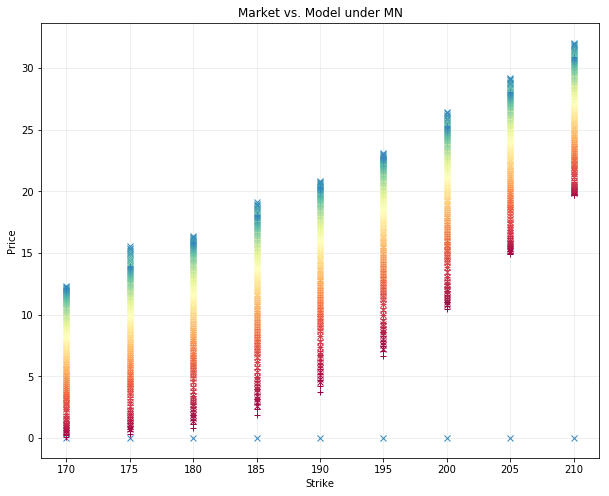

In [23]:
# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_MN[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
#plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model under MN')
#plt.savefig('MarketvsModel_NelderMead.png')
plt.show() 

#### C) BFGS Algorithm (Gradient-based) from exampleCalibration_BFGS.py

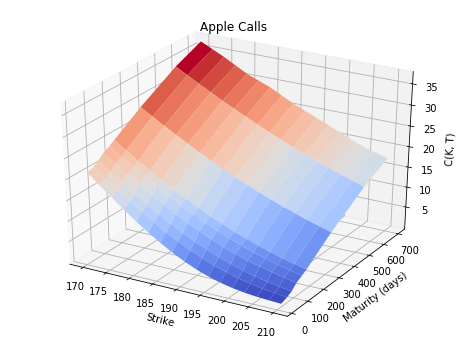

 
i = 1
x_i = [ 3.00000313  0.06123909  0.10000256 -0.60000116  0.04052367]
f_i = 2.2494978012832205
 
i = 2
x_i = [ 3.00001273  0.06078237  0.10025099 -0.60004406  0.04173431]
f_i = 2.2492866863866676
 
i = 3
x_i = [ 3.00082137  0.06094427  0.13442201 -0.60591409  0.04187283]
f_i = 2.247569964279837
 
i = 4
x_i = [ 3.00411665  0.06124184  0.18691869 -0.62115842  0.04211359]
f_i = 2.2465922468250854
 
i = 5
x_i = [ 3.00667093  0.06130245  0.18383104 -0.62141183  0.04213816]
f_i = 2.2465545626232934
 
i = 6
x_i = [ 3.00998283  0.06131086  0.18408707 -0.62303977  0.04214178]
f_i = 2.2465444746758254
 
i = 7
x_i = [ 3.04380276  0.06132828  0.18401948 -0.63874405  0.04210444]
f_i = 2.2464588783936326
 
i = 8
x_i = [ 3.11291928  0.06130026  0.18129851 -0.66992414  0.04196978]
f_i = 2.246309028329666
 
i = 9
x_i = [ 3.24561014  0.0611775   0.17347786 -0.72889798  0.04167608]
f_i = 2.246036643352723
 
i = 10
x_i = [ 3.50061628  0.0608728   0.15640382 -0.8416626   0.04109693]
f_i = 2.245526632

In [24]:
import warnings
warnings.filterwarnings("ignore")

import readPlotOptionSurfaceedited
import modulesForCalibration as mfc

from scipy.optimize import fmin_bfgs

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

params = [ 3.  ,  0.06,  0.1 , -0.6 ,  0.04]

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1

arg = (marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)

num_iter = 1
[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(
        mfc.eValue,
        params,
        args=arg, 
        fprime=None,
        callback=callbackF,
        maxiter=20,
        full_output=True, 
        retall=False)

print('optimal params = ')
print(xopt)
print('f = ' + str(fopt))


In [ ]:
#optimal params = 
#[ 4.97744222  0.06012108  0.27321345 -1.43170033  0.03724083]
#f = 2.243977495403778

In [25]:

        
params_BFGS = xopt
lenT = len(maturities)
lenK = len(strikes)
modelPrices_BFGS = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params_BFGS, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices_BFGS[i,j] = cT_km[0]

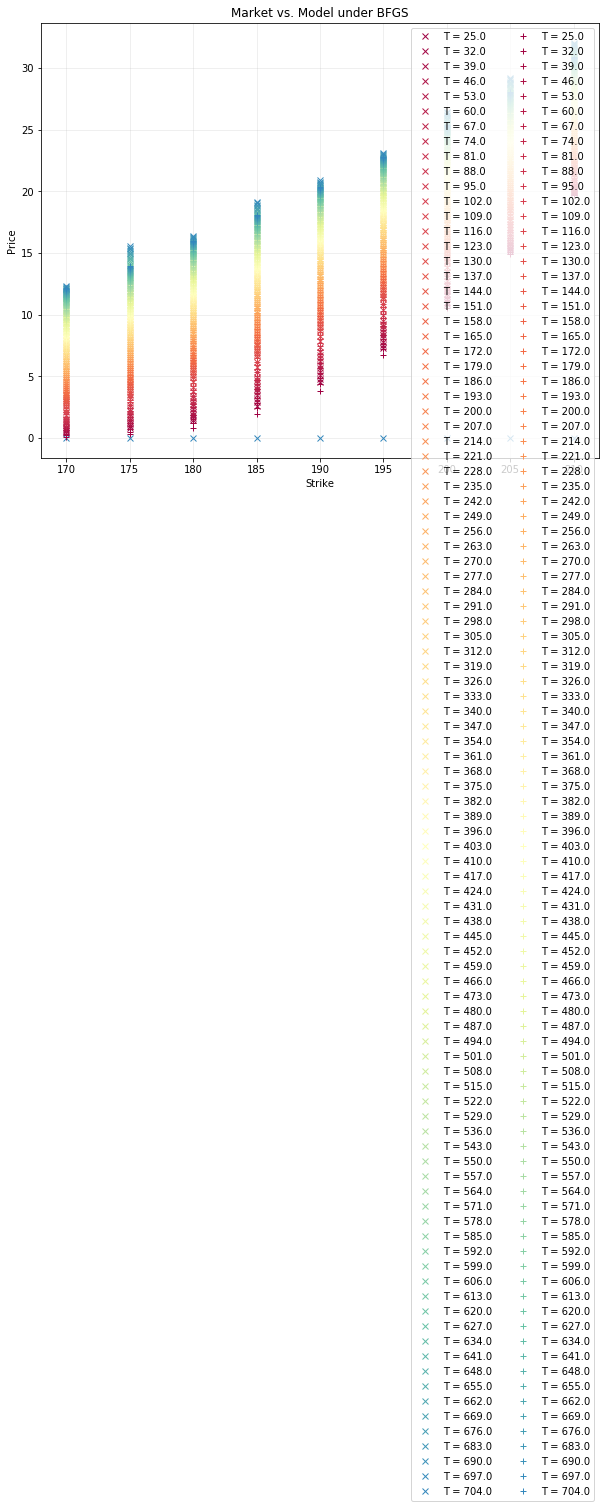

In [26]:

# plot
fig = plt.figure(figsize=(10,8))
labels = []
colormap = cm.Spectral
plt.gca().set_color_cycle([colormap(i) for i in np.linspace(0, 0.9, len(maturities))])
for i in range(len(maturities)):
    plt.plot(strikes, marketPrices[i,:], 'x')
    labels.append('T = ' + str(maturities[i]))
    
for i in range(len(maturities)):
    plt.plot(strikes, modelPrices_BFGS[i,:], '+')
    labels.append('T = ' + str(maturities[i]))
plt.legend(labels, loc='upper right', ncol=2)
plt.grid(alpha=0.25)
plt.xlabel('Strike')
plt.ylabel('Price')
plt.title('Market vs. Model under BFGS')
#plt.savefig('MarketvsModel_BFGS.png')
plt.show() 


### Evaluate which Optimization yields best results: Loss Function

In [27]:
# set 1: Brute-Force vs. Nelder-Mead
params_BF = [3.5, 0.060000000000000005, 0.10999999999999999, -0.7, 0.04]
params_NM = [ 6.87641013,  0.06001665 , 0.56731478 ,-1.64054437 , 0.03433526]

In [28]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.05):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_NM)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[ 8.5646152   0.06002497  0.79597217 -2.11081655  0.03150289]

-0.45
[ 8.39579469  0.06002414  0.77310643 -2.06378934  0.03178613]

-0.4
[ 8.22697418  0.06002331  0.75024069 -2.01676212  0.03206936]

-0.35000000000000003
[ 8.05815368  0.06002248  0.72737495 -1.9697349   0.0323526 ]

-0.30000000000000004
[ 7.88933317  0.06002164  0.70450921 -1.92270768  0.03263584]

-0.25000000000000006
[ 7.72051266  0.06002081  0.68164348 -1.87568046  0.03291907]

-0.20000000000000007
[ 7.55169216  0.06001998  0.65877774 -1.82865324  0.03320231]

-0.15000000000000008
[ 7.38287165  0.06001915  0.635912   -1.78162603  0.03348555]

-0.10000000000000007
[ 7.21405114  0.06001832  0.61304626 -1.73459881  0.03376879]

-0.05000000000000007
[ 7.04523064  0.06001748  0.59018052 -1.68757159  0.03405202]

-6.938893903907228e-17
[ 6.87641013  0.06001665  0.56731478 -1.64054437  0.03433526]

0.04999999999999993
[ 6.70758962  0.06001582  0.54444904 -1.59351715  0.0346185 ]

0.09999999999999994
[ 6.53876912  0.0

In [ ]:
#optimal results are:
#[ 6.87641013  0.06001665  0.56731478 -1.64054437  0.03433526]
#NM is better

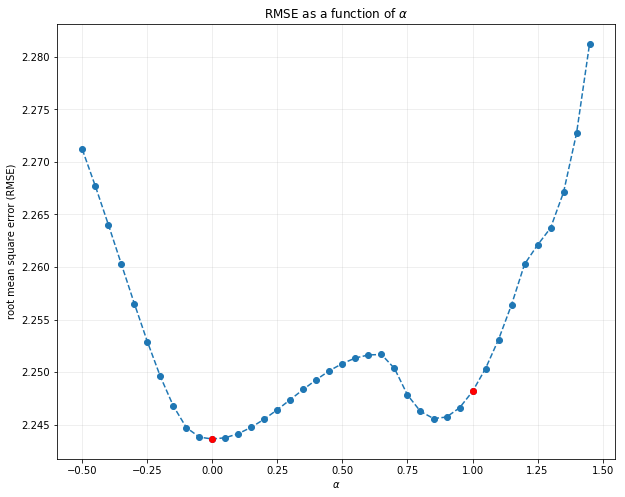

In [30]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.plot(iArray[10], rmseArray[10], 'ro')
plt.plot(iArray[30], rmseArray[30], 'ro')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
#plt.savefig('NelderMeadvsBruteForce.png')
plt.show()

***Concludes that NM Parameters yield better result ***

In [31]:
# set 2: Brute-Force vs. BFGS
params_BF = [3.5, 0.060000000000000005, 0.10999999999999999, -0.7, 0.04]
params_BFGS = [ 4.97744222 , 0.06012108 , 0.27321345, -1.43170033 , 0.03724083]

In [32]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.05):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_BFGS)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[ 5.71616333  0.06018162  0.35482018 -1.79755049  0.03586124]

-0.45
[ 5.64229122  0.06017557  0.3466595  -1.76096548  0.0359992 ]

-0.4
[ 5.56841911  0.06016951  0.33849883 -1.72438046  0.03613716]

-0.35000000000000003
[ 5.494547    0.06016346  0.33033816 -1.68779545  0.03627512]

-0.30000000000000004
[ 5.42067489  0.0601574   0.32217749 -1.65121043  0.03641308]

-0.25000000000000006
[ 5.34680278  0.06015135  0.31401681 -1.61462541  0.03655104]

-0.20000000000000007
[ 5.27293066  0.0601453   0.30585614 -1.5780404   0.036689  ]

-0.15000000000000008
[ 5.19905855  0.06013924  0.29769547 -1.54145538  0.03682695]

-0.10000000000000007
[ 5.12518644  0.06013319  0.2895348  -1.50487036  0.03696491]

-0.05000000000000007
[ 5.05131433  0.06012713  0.28137412 -1.46828535  0.03710287]

-6.938893903907228e-17
[ 4.97744222  0.06012108  0.27321345 -1.43170033  0.03724083]

0.04999999999999993
[ 4.90357011  0.06011503  0.26505278 -1.39511531  0.03737879]

0.09999999999999994
[ 4.829698    0.0

In [ ]:
#optimal results are 
#[ 4.97744222  0.06012108  0.27321345 -1.43170033  0.03724083]

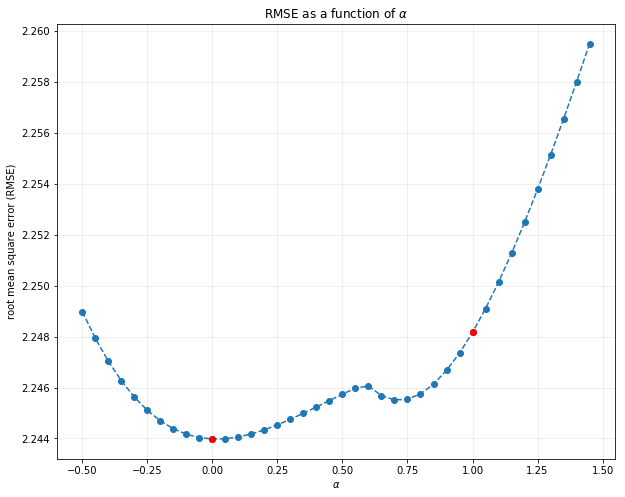

In [33]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.plot(iArray[10], rmseArray[10], 'ro')
plt.plot(iArray[30], rmseArray[30], 'ro')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
#plt.savefig('NelderMeadvsBruteForce.png')
plt.show()

In [ ]:
#BFGD yields better result

In [34]:
# set 3: NelderMead vs. BFGS
params_NM = [ 6.87641013,  0.06001665 , 0.56731478 ,-1.64054437 , 0.03433526]
params_BFGS = [ 4.97744222 , 0.06012108 , 0.27321345, -1.43170033 , 0.03724083]

In [35]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(-0.5, 1.5, 0.05):
    
    params = i*np.array(params_NM) + (1.0-i)*np.array(params_BFGS)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = mfc.eValue(params, marketPrices, maturities_years, strikes, r, q, S0, alpha, eta, n, model)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


-0.5
[ 4.02795827  0.0601733   0.12616278 -1.32727831  0.03869362]

-0.45
[ 4.12290666  0.06016807  0.14086785 -1.33772051  0.03854834]

-0.4
[ 4.21785506  0.06016285  0.15557292 -1.34816271  0.03840306]

-0.35000000000000003
[ 4.31280345  0.06015763  0.17027798 -1.35860492  0.03825778]

-0.30000000000000004
[ 4.40775185  0.06015241  0.18498305 -1.36904712  0.0381125 ]

-0.25000000000000006
[ 4.50270024  0.06014719  0.19968812 -1.37948932  0.03796722]

-0.20000000000000007
[ 4.59764864  0.06014197  0.21439318 -1.38993152  0.03782194]

-0.15000000000000008
[ 4.69259703  0.06013674  0.22909825 -1.40037372  0.03767667]

-0.10000000000000007
[ 4.78754543  0.06013152  0.24380332 -1.41081593  0.03753139]

-0.05000000000000007
[ 4.88249382  0.0601263   0.25850838 -1.42125813  0.03738611]

-6.938893903907228e-17
[ 4.97744222  0.06012108  0.27321345 -1.43170033  0.03724083]

0.04999999999999993
[ 5.07239062  0.06011586  0.28791852 -1.44214253  0.03709555]

0.09999999999999994
[ 5.16733901  0.0

In [ ]:
#Optimal results are:
#[ 6.87641013  0.06001665  0.56731478 -1.64054437  0.03433526]

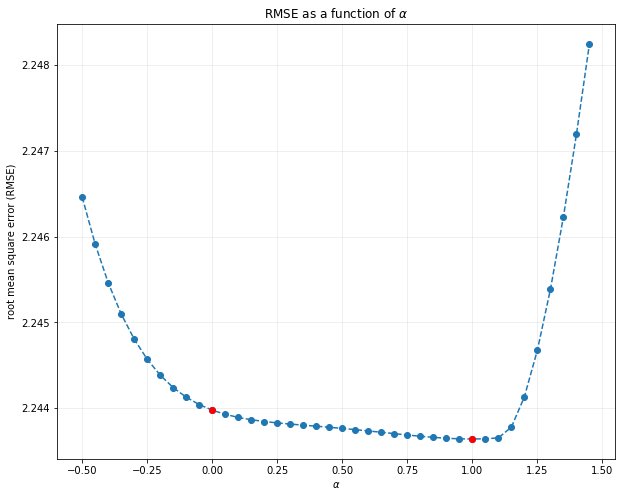

In [36]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.plot(iArray[10], rmseArray[10], 'ro')
plt.plot(iArray[30], rmseArray[30], 'ro')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
#plt.savefig('NelderMeadvsBruteForce.png')
plt.show()

In [ ]:
#NM is the best

# II. Local Volatility Surface

** Explicitly compute local volatility for each point in our grid **

## 1. Calculate Finite differences

In [37]:
deltaK = 5
deltaT = 1/52 

In [38]:

params_NM = [ 6.87641013,  0.06001665 , 0.56731478 ,-1.64054437 , 0.03433526]
lenT = len(maturities)
lenK = len(strikes)
modelPrices = np.zeros((lenT, lenK))

for i in range(lenT):
    for j in range(lenK):
        T = maturities_years[i]
        K = strikes[j]
        [km, cT_km] = mfc.genericFFT(params_NM, S0, K, r, q, T, alpha, eta, n, model)
        modelPrices[i,j] = cT_km[0]

In [39]:
modelPrices.shape

(98, 9)

In [40]:
# v_j,k Option prices for all points on the grid
modelPrices_df = pd.DataFrame(modelPrices, columns = strikes)
modelPrices_df.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,0.112272,0.320075,0.816653,1.853854,3.724562,6.612575,10.443328,14.919791,19.725018
1,0.222606,0.530413,1.160945,2.325290,4.246811,7.062184,10.728797,15.035905,19.724473
2,0.358776,0.759852,1.502055,2.764064,4.723115,7.485755,11.026133,15.188261,19.760858
3,0.513108,0.999331,1.836085,3.176413,5.164950,7.887388,11.327333,15.365354,19.827909
4,0.680000,1.243516,2.161571,3.566681,5.579362,8.270089,11.628064,15.559258,19.919679


#### dC/dT for every point on the grid

In [41]:
dcdT = (modelPrices_df.diff()/deltaT).shift(-1)
dcdT.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,5.737333,10.937549,17.903194,24.514691,27.156948,23.379696,14.844393,6.037924,-0.028361
1,7.080834,11.930858,17.737704,22.816253,24.767808,22.025672,15.461476,7.922524,1.892027
2,8.025289,12.452886,17.369565,21.442165,22.975442,20.884955,15.662399,9.208844,3.486664
3,8.678376,12.697608,16.925270,20.293923,21.549402,19.900429,15.637989,10.083001,4.772005
4,9.123219,12.773149,16.457591,19.309036,20.367410,19.033290,15.484488,10.668926,5.792629


In [19]:
(16.010738 - 15.703254)/ deltaT

15.989168000000028

#### dC/dK for every point on the grid

In [42]:
dcdK = (modelPrices_df.diff(axis=1, periods = 2)/(2*deltaK)).shift(-1,axis=1)
dcdK.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.070438,0.153378,0.290791,0.475872,0.671877,0.830722,0.928169,NaN
1,NaN,0.093834,0.179488,0.308587,0.473689,0.648199,0.797372,0.899568,NaN
2,NaN,0.114328,0.200421,0.322106,0.472169,0.630302,0.770251,0.873472,NaN
3,NaN,0.132298,0.217708,0.332887,0.471098,0.616238,0.747797,0.850058,NaN
4,NaN,0.148157,0.232317,0.341779,0.470341,0.604870,0.728917,0.829161,NaN


In [22]:
(11.277736 - 20.440630)/(2*deltaK)

-0.9162893999999998

In [43]:
# For vol surface calculation
dcdK_v = dcdK
for i in modelPrices_df.columns:
    dcdK_v[i] = i * dcdK[i]*(r-q)

In [44]:
dcdK_v.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.240370,0.538356,1.049028,1.763106,2.554811,3.239814,3.710356,NaN
1,NaN,0.320208,0.630002,1.113226,1.755019,2.464775,3.109751,3.596021,NaN
2,NaN,0.390144,0.703478,1.161997,1.749386,2.396723,3.003977,3.491706,NaN
3,NaN,0.451466,0.764156,1.200888,1.745416,2.343246,2.916407,3.398105,NaN
4,NaN,0.505586,0.815431,1.232968,1.742613,2.300019,2.842776,3.314573,NaN


In [25]:
(r-q)*175*(-0.916289)

-3.1268362125

#### d2C/dK2 for every point on the grid

In [45]:
# For d2C/dK2: - 2*v_j,k
modelPrices_df_neg2 = modelPrices_df*(-2)

In [46]:
modelPrices_df_neg2.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,-0.224545,-0.640151,-1.633306,-3.707707,-7.449123,-13.225149,-20.886656,-29.839582,-39.450037
1,-0.445212,-1.060826,-2.321890,-4.650580,-8.493621,-14.124368,-21.457595,-30.071809,-39.448946
2,-0.717551,-1.519705,-3.004110,-5.528128,-9.446229,-14.971509,-22.052267,-30.376522,-39.521716
3,-1.026216,-1.998662,-3.672170,-6.352827,-10.329900,-15.774777,-22.654667,-30.730708,-39.655819
4,-1.360000,-2.487031,-4.323142,-7.133362,-11.158723,-16.540178,-23.256128,-31.118516,-39.839357


In [47]:
d2cdK2 = pd.DataFrame()
for i in range(len(modelPrices_df.columns)): 
    try:
        d2cdK2[modelPrices_df.columns[i]] = (modelPrices_df[modelPrices_df.columns[i-1]] + modelPrices_df[modelPrices_df.columns[i+1]] -2* modelPrices_df[modelPrices_df.columns[i]])/(deltaK**2)
    except: 
        d2cdK2[modelPrices_df.columns[i]] = np.repeat(np.nan, len(modelPrices_df))

In [48]:
modelPrices_df.shape == modelPrices_df_neg2.shape == d2cdK2.shape

True

In [49]:
d2cdK2[modelPrices_df.columns[0]] = np.repeat(np.nan, len(modelPrices_df))
d2cdK2.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.011551,0.021625,0.033340,0.040692,0.03771,0.025828,0.013151,NaN
1,NaN,0.012909,0.021353,0.030287,0.035754,0.03405,0.025620,0.015258,NaN
2,NaN,0.013645,0.020792,0.027882,0.032144,0.03111,0.024870,0.016419,NaN
3,NaN,0.014021,0.020143,0.025928,0.029356,0.02870,0.023923,0.016981,NaN
4,NaN,0.014182,0.019482,0.024303,0.027122,0.02669,0.022929,0.017169,NaN


In [349]:
(15.627181 - 2* 17.977095 + 20.385484)/(deltaK**2)

0.00935600000000079

In [50]:
# For vol surface calculation
d2cdK2_v = d2cdK2
for i in modelPrices_df.columns:
    d2cdK2_v[i] = i**2 * d2cdK2[i] * 1/2

In [51]:
d2cdK2_v.head()

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,176.874540,350.323755,570.535767,734.494123,716.954319,516.567153,276.327079,NaN
1,NaN,197.669266,345.910512,518.286837,645.361709,647.367815,512.395383,320.617917,NaN
2,NaN,208.939532,336.834807,477.124764,580.191611,591.470208,497.399116,344.999783,NaN
3,NaN,214.700351,326.316296,443.698469,529.877051,545.663695,478.460670,356.821341,NaN
4,NaN,217.155416,315.611723,415.881784,489.549859,507.441732,458.575318,360.765098,NaN


In [366]:
0.009356*172.5**2*0.5

139.1997375

In [52]:
dcdT.shape == modelPrices_df.shape == dcdK_v.shape == d2cdK2_v.shape

True

## 2. Calculate Local Volatility Surface

In [53]:
# Vol Surface 
vol_surface = ((dcdT + dcdK_v + q*modelPrices_df)/d2cdK2_v)**0.5

In [54]:
vol_surface

,170.0,175.0,180.0,185.0,190.0,195.0,200.0,205.0,210.0
0,NaN,0.251408,0.229463,0.211714,0.198493,0.190314,0.187375,0.188542,NaN
1,NaN,0.248980,0.230470,0.214925,0.202807,0.194642,0.190653,0.190159,NaN
2,NaN,0.247963,0.231685,0.217726,0.206532,0.198559,0.194007,0.192440,NaN
3,NaN,0.247522,0.232890,0.220183,0.209789,0.202081,0.197225,0.194927,NaN
4,NaN,0.247340,0.234015,0.222344,0.212652,0.205237,0.200231,0.197424,NaN
5,NaN,0.247280,0.235038,0.224248,0.215178,0.208062,0.203001,0.199841,NaN
6,NaN,0.247275,0.235956,0.225928,0.217411,0.210588,0.205536,0.202134,NaN
7,NaN,0.247290,0.236770,0.227411,0.219388,0.212848,0.207844,0.204281,NaN
8,NaN,0.247307,0.237488,0.228719,0.221142,0.214869,0.209942,0.206278,NaN
9,NaN,0.247315,0.238118,0.229873,0.222698,0.216680,0.211845,0.208125,NaN


In [55]:
vol_surface_new = vol_surface[[175.0, 180.0,185.0,190.0,195.0,200.0,205.0]]
#pd.DataFrame.to_csv(vol_surface)

In [56]:
vol_surface_new = vol_surface_new.loc[np.arange(0,97)]

In [107]:
vol_surface_new.to_csv('heston_call.csv')


In [57]:
import plotly
plotly.tools.set_credentials_file(username='lisayhe', api_key='FioDIUbTjZMAu76NCdei')

In [58]:

data = [
    go.Surface(
        z=vol_surface_new.as_matrix()
    )
]
layout = go.Layout(
    title='Apple Heston Put Vol Surface',
    autosize=True,
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Apple_Heston_Put', auto_open=True)